# Install and Imports

In [1]:
#!pip uninstall tensorflow
!pip install tensorflow
!pip install scapy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.6 MB/s eta 0:00:00


In [2]:
from sklearn.model_selection import StratifiedKFold

import random
import gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import regularizers

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report

from scapy.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Auxiliar

In [3]:
def reset_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

In [2]:
def plot_losses(losses):
    for fold_loss in losses:
        plt.figure(figsize=(8, 5))  # Create a new figure for each fold
        epochs = np.arange(len(fold_loss["train_loss"]))

        plt.plot(epochs, fold_loss["train_loss"], label="Train Loss", linestyle='dashed')
        plt.plot(epochs, fold_loss["val_loss"], label="Val Loss")
        
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(f"Training and Validation Loss - Fold {fold_loss['fold']}")
        plt.legend()
        plt.show()  # Show each plot separately

# Reading the data

In [5]:
input_file_path = "/kaggle/input/tow-ids/"

y_train = pd.read_csv(f"{input_file_path}/y_train_TOW_IDS_dataset_one_class_Wsize_44_Cols_116_Wslide_1_MC_False_sumX_False.csv")
y_train = y_train['Class'].values

y_test = pd.read_csv(f"{input_file_path}/y_test_TOW_IDS_dataset_one_class_Wsize_44_Cols_116_Wslide_1_MC_False_sumX_False.csv")
y_test = y_test['Class'].values

x_test = np.load(f"{input_file_path}/X_test_TOW_IDS_dataset_one_class_Wsize_44_Cols_116_Wslide_1_MC_False_sumX_False-001.npz")
x_test = x_test['arr_0']


In [6]:
y_train.shape, y_test.shape, x_test.shape

((1203692,), (791566,), (791566, 44, 116))

In [7]:
prefix_x_train_path = "X_train_TOW_IDS_dataset_one_class_Wsize_44_Cols_116_Wslide_1_MC_False_sumX_False"
chunk_size = 150467
num_chunks = 8 

x_train = []

for i in range(0, chunk_size * num_chunks, chunk_size):
    file_path = f"{input_file_path}/{prefix_x_train_path}_{i}.npz"
    aux = np.load(file_path)['arr_0']
    x_train.append(aux)

x_train = np.concatenate(x_train, axis=0)

In [8]:
x_train.shape

(1203692, 44, 116)

# Model arch

In [9]:
def create_model():
  inputs = keras.Input(shape=(44, 116, 1))

  x = layers.Conv2D(32, (5, 5), strides=(1,1), padding="same", activation="relu", kernel_regularizer='l2')(inputs)
  x = layers.BatchNormalization(momentum=0.99, epsilon=0.001)(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = layers.Conv2D(64, (5, 5), strides=(1,1), padding="same", activation="relu", kernel_regularizer='l2')(x)
  x = layers.BatchNormalization(momentum=0.99, epsilon=0.001)(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)

  x = layers.Flatten()(x)
  x = layers.Dropout(0.3)(x)
  x = layers.Dense(units=64, activation="relu")(x)
  x = layers.Dropout(0.3)(x)
  outputs = layers.Dense(units=1, activation="sigmoid")(x)

  model = keras.Model(inputs=inputs, outputs=outputs)

  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[tf.keras.metrics.BinaryAccuracy(name="binary_accuracy")])

  return model

In [10]:
reset_seeds()
model = create_model()
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 44, 116, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 44, 116, 32)         │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 44, 116, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 22, 58, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 58, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 58, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20416)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20416)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       1,306,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,359,233 (5.19 MB)

 Trainable params: 1,359,041 (5.18 MB)

 Non-trainable params: 192 (768.00 B)

None


# Training the 5-fold

In [11]:
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
models = []
metrics_list = []  # Initialize metrics_list
losses = []  # List to store training and validation losses

for fold_number, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):
    print(f"Fold atual: {fold_number + 1}")

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"model_{fold_number}.keras",
        monitor='binary_accuracy',
        save_best_only=True,
        mode='max'
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1
    )
    callbacks_list = [early_stopping, checkpoint]

    model = create_model()
    history = model.fit(
        x_train[train_index],
        y_train[train_index],
        batch_size=64,
        epochs=30,
        validation_data=(x_train[val_index], y_train[val_index]),
        callbacks=callbacks_list
    )
    
    # Save training and validation loss
    losses.append({
        "fold": fold_number + 1,
        "train_loss": history.history["loss"],
        "val_loss": history.history["val_loss"]
    })

    predictions = model.predict(x_train[val_index])
    y_pred = (predictions > 0.5).astype(int)  # Assign to y_pred

    report = classification_report(y_train[val_index], y_pred, output_dict=True)
    metrics_dict = {
        "fold": fold_number + 1,
        "accuracy": report["accuracy"],
        "precision": report["1"]["precision"],  # Precisão da classe 1
        "recall": report["1"]["recall"],  # Recall da classe 1
        "f1-score": report["1"]["f1-score"],  # F1-score da classe 1
        "roc_auc": roc_auc_score(y_train[val_index], y_pred)  # roc_auc da classe 1
    }
    metrics_list.append(metrics_dict)

    del model, predictions, y_pred
    gc.collect()
    tf.keras.backend.clear_session()

metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv("models_metrics_5fold.csv", index=False)

Fold atual: 1
Epoch 1/30
15047/15047 ━━━━━━━━━━━━━━━━━━━━ 134s 8ms/step - binary_accuracy: 0.9532 - loss: 0.2126 - val_binary_accuracy: 0.9889 - val_loss: 0.0655
Epoch 2/30
15047/15047 ━━━━━━━━━━━━━━━━━━━━ 121s 8ms/step - binary_accuracy: 0.9928 - loss: 0.0557 - val_binary_accuracy: 0.9948 - val_loss: 0.0466
Epoch 3/30
15047/15047 ━━━━━━━━━━━━━━━━━━━━ 118s 8ms/step - binary_accuracy: 0.9941 - loss: 0.0484 - val_binary_accuracy: 0.9547 - val_loss: 0.1758
Epoch 4/30
15047/15047 ━━━━━━━━━━━━━━━━━━━━ 117s 8ms/step - binary_accuracy: 0.9943 - loss: 0.0466 - val_binary_accuracy: 0.9930 - val_loss: 0.0513
Epoch 5/30
15047/15047 ━━━━━━━━━━━━━━━━━━━━ 118s 8ms/step - binary_accuracy: 0.9947 - loss: 0.0443 - val_binary_accuracy: 0.9938 - val_loss: 0.0418
Epoch 6/30
15047/15047 ━━━━━━━━━━━━━━━━━━━━ 118s 8ms/step - binary_accuracy: 0.9947 - loss: 0.0436 - val_binary_accuracy: 0.9961 - val_loss: 0.0388
Epoch 7/30
15047/15047 ━━━━━━━━━━━━━━━━━━━━ 118s 8ms/step - binary_accuracy: 0.9950 - loss: 0.0418

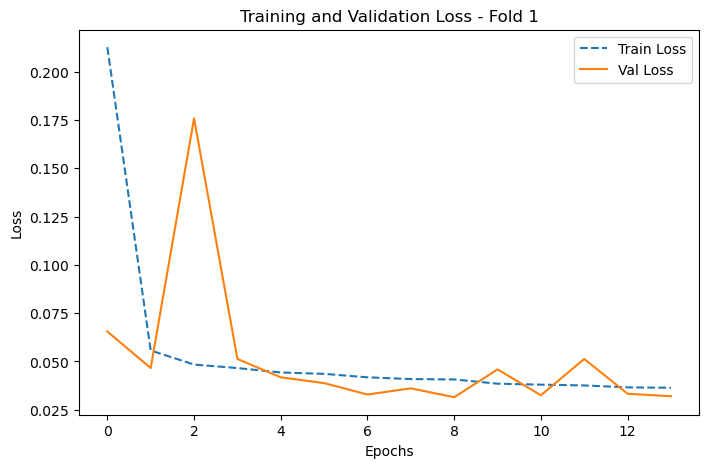

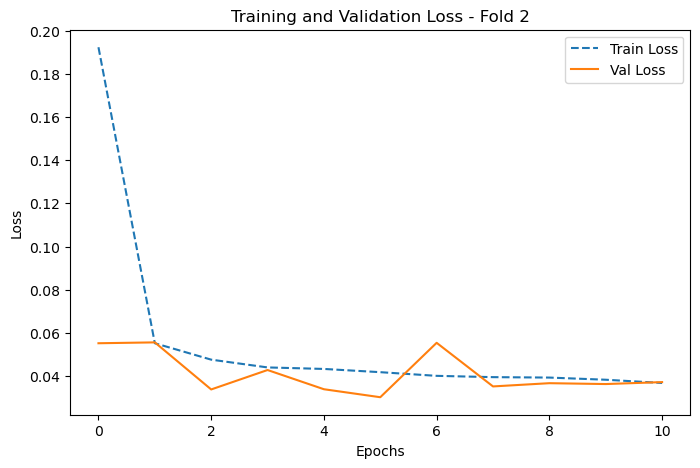

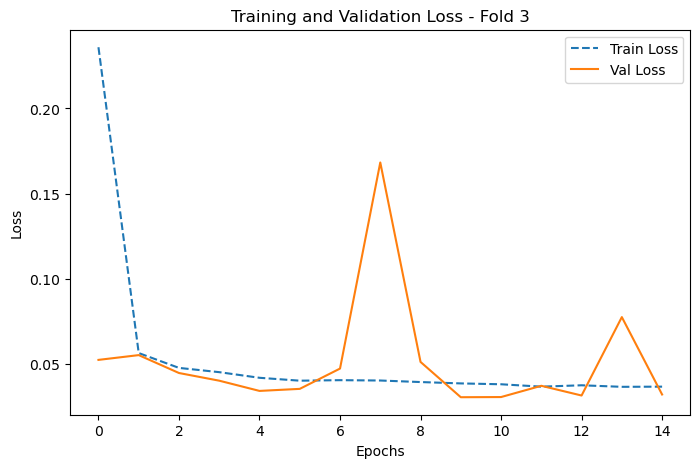

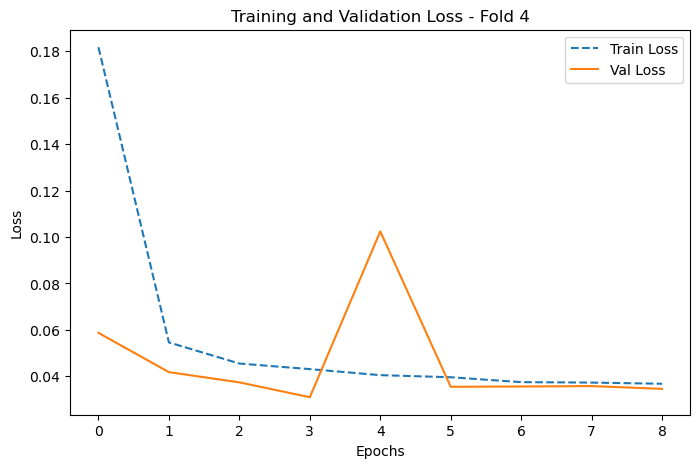

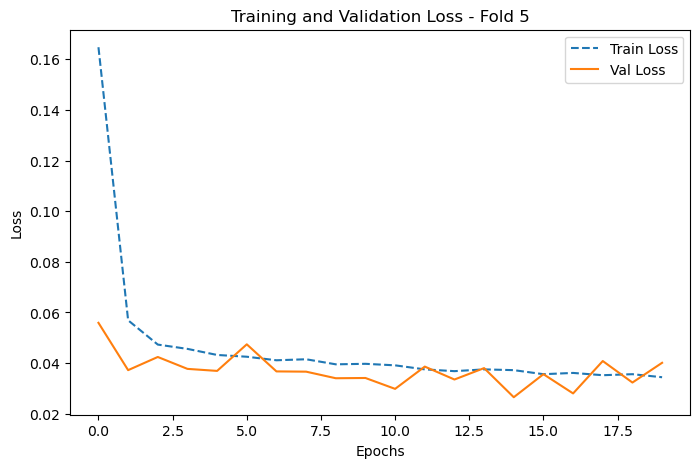

In [ ]:
# Colocando os valores manualmente para evitar o re-treinamento

fold_losses = [
    {
        'fold': 1,
        "train_loss": [0.2126, 0.0557, 0.0484, 0.0466, 0.0443, 0.0436, 0.0418, 0.0409, 0.0407, 0.0385, 0.0380, 0.0376, 0.0366, 0.0364],
        "val_loss": [0.0655, 0.0466, 0.1758, 0.0513, 0.0418, 0.0388, 0.0329, 0.0361, 0.0315, 0.0459, 0.0325, 0.0513, 0.0333, 0.0320]
    },
    {
        'fold': 2,
        "train_loss": [0.1923, 0.0552, 0.0476, 0.0440, 0.0433, 0.0418, 0.0401, 0.0395, 0.0393, 0.0383, 0.0368],
        "val_loss": [0.0552, 0.0556, 0.0338, 0.0428, 0.0339, 0.0302, 0.0554, 0.0352, 0.0367, 0.0363, 0.0372]
    },
    {
        'fold': 3,
        "train_loss": [0.2359, 0.0565, 0.0478, 0.0453, 0.0420, 0.0403, 0.0406, 0.0404, 0.0395, 0.0387, 0.0382, 0.0368, 0.0376, 0.0367, 0.0368],
        "val_loss": [0.0525, 0.0553, 0.0448, 0.0403, 0.0343, 0.0355, 0.0474, 0.1683, 0.0513, 0.0306, 0.0307, 0.0373, 0.0316, 0.0776, 0.0322]
    },
    {
        'fold': 4,
        "train_loss": [0.1817, 0.0546, 0.0455, 0.0431, 0.0405, 0.0396, 0.0375, 0.0373, 0.0368],
        "val_loss": [0.0587, 0.0418, 0.0374, 0.0310, 0.1024, 0.0355, 0.0356, 0.0358, 0.0346]
    },
    {
        'fold': 5,
        "train_loss": [0.1648, 0.0569, 0.0473, 0.0456, 0.0432, 0.0425, 0.0411, 0.0415, 0.0395, 0.0397, 0.0391, 0.0375, 0.0368, 0.0375, 0.0372, 0.0356, 0.0361, 0.0352, 0.0356, 0.0344],
        "val_loss": [0.0559, 0.0372, 0.0424, 0.0377, 0.0369, 0.0474, 0.0367, 0.0366, 0.0340, 0.0341, 0.0298, 0.0386, 0.0335, 0.0380, 0.0265, 0.0356, 0.0280, 0.0408, 0.0323, 0.0401]
    }
]

plot_losses(fold_losses)